# Librerias

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils as u
import re
import geopandas as gpd
import ast
import nltk
nltk.download('stopwords')


pd.options.display.max_columns = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Limpieza de Datos

Nuestra base principal es la base de los restaurantes de google maps, lo que haremos será unificar las 4 fuentes en un mismo dataframe para poder modelar.

In [11]:
''' 
Lectura de datos de id de sitios y sus nombres.
'''

restaurantes = pd.read_csv('../data/raw/lugares_madrid.csv')

In [12]:
''' 
Lectura de datos de detalle de sitios de Madrid.
'''
detalle_restaurantes = pd.read_csv('../data/raw/detalle_sitios.csv')

In [13]:
restaurantes = pd.merge(restaurantes, detalle_restaurantes, left_on='id', right_on='place_id') # Unimos las 2 fuentes por el place_id

In [14]:
restaurantes.drop(['id', 'summary'], inplace=True, axis=1) # Quitamos las  variables de id y summary de dataframe
restaurantes = restaurantes[restaurantes['rating'].notnull()] # Quitamos los restaurantes que tienen rating vacios

In [15]:
''' 
Nos quitamos registros que en google maps estan marcados con restaurantes pero no lo son 
'''

tipos = ['beauty_salon', 'clothing_store', 'doctor', 'shopping_mall', 'physiotherapist']

for i in tipos:
    valor = restaurantes[restaurantes['types'].str.contains(i)].index
    restaurantes.drop(index=valor, axis=0, inplace=True)
    restaurantes.reset_index(drop=True, inplace=True)

In [16]:
''' 
Ahora que hemos quitado los registros vamos a limpiar un poco la variable types para quedarnos con las categorias
que importan y no tan generales.
'''

rem = ['food', 'point_of_interest', 'establishment', 'restaurant', 'point_of_interest']

for i, j in enumerate(restaurantes['types']):
    list = ast.literal_eval(j)
    lista_filtrada = [k for k in list if k not in rem]
    if len(lista_filtrada)>0:
        restaurantes.at[i, 'types'] = lista_filtrada
    else:
        restaurantes.at[i, 'types'] = None


In [17]:
restaurantes_sinnan = restaurantes[restaurantes['types'].notna()].reset_index(drop=True) #Creamos un df sin tipos none

In [553]:
''' 
Vamos a crear una columna por cada categoria y marcamos con 1 si tiene esa etiqueta.
'''

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
types_encode = mlb.fit_transform(restaurantes_sinnan['types'])
types_df = pd.DataFrame(types_encode, columns=mlb.classes_)

restaurantes_sinnan = pd.concat([restaurantes_sinnan, types_df], axis=1) 

restaurantes = pd.concat([restaurantes_sinnan, restaurantes[restaurantes['types'].isna()]], axis=0)
restaurantes.drop(columns='types', inplace=True)

In [554]:
for i in types_df.columns:
    restaurantes[i] = restaurantes[i].fillna(0) #Rellenamos los tipos que vienen vacios con 0 

In [555]:
print('Distribución de precios:\n')
print(restaurantes['price_level'].value_counts(dropna=False), '\n')
print('Total de registros:', len(restaurantes['price_level']))

Distribución de precios:

price_level
1.0    1063
NaN     722
2.0     637
3.0     104
4.0      16
Name: count, dtype: int64 

Total de registros: 2542


In [556]:
''' 
Para el precio hacer una distribucion proporcional de los nan en todo el data ser.
'''

'''
dist = restaurantes['price_level'].value_counts(normalize=True, dropna=True)

n_missing = restaurantes['price_level'].isna().sum()

n_to_assign = round((dist * n_missing), 0).astype(int)

if n_to_assign.sum() != n_missing:
    dif = n_missing - (n_to_assign.sum())
    n_to_assign.iloc[0] += dif '''

"\ndist = restaurantes['price_level'].value_counts(normalize=True, dropna=True)\n\nn_missing = restaurantes['price_level'].isna().sum()\n\nn_to_assign = round((dist * n_missing), 0).astype(int)\n\nif n_to_assign.sum() != n_missing:\n    dif = n_missing - (n_to_assign.sum())\n    n_to_assign.iloc[0] += dif "

In [557]:
''' 
Con una semilla establecida, generamos random de los valores del precio y asignamos a los datos nulls
'''
'''
valores = []
for i, j in n_to_assign.items():
    for k in range(j):
        valores.append(i)

np.random.seed(42)
np.random.shuffle(valores) 

restaurantes.loc[restaurantes['price_level'].isna(), 'price_level'] = valores '''

"\nvalores = []\nfor i, j in n_to_assign.items():\n    for k in range(j):\n        valores.append(i)\n\nnp.random.seed(42)\nnp.random.shuffle(valores) \n\nrestaurantes.loc[restaurantes['price_level'].isna(), 'price_level'] = valores "

In [558]:
restaurantes['num_days_open'].value_counts()

num_days_open
7    1418
6     798
0     146
5     146
4      16
2       9
3       7
1       2
Name: count, dtype: int64

In [559]:
''' 
Vamos hacer un proceso de limpieza para el dataframe y vamos a asumir cierto valores para los registros sin datos.
- todas las variables booleanas según cada un asumiremos que los valores vacios son verdaderos o falsos.
- dine_in: Comer dentro del restaurante todos los vacios asumimos que son True (lo más común).
- reservable: Si se puedo o no hacer reservas es dificil determinar su valor pero asumimos que es Falso. 
- serves_beer: Si sirve cerveza, asumimos que siempre. 
- serves_breakfast: Sirven desayunos, asumimos que no ya que lo común es que sea almuerzos o cena. 
- serves_brunch:Sirven brunch, asumimos que no ya que lo común es que sea almuerzos o cena. 
- serves_dinner: Sirven cena, asumimos que si ya que lo común es que sea almuerzos o cena. 
- serves_lunch: Sirven almuerzo, asumimos que si ya que lo común es que sea almuerzos o cena. 
- serves_vegetarian_food: Sirven comida vegetariana, asumimos que no ya que no es aun tan común aquí en Madrid. 
- serves_wine: Si sirve vino, asumimos que siempre.
- takeout: Si sirven para llevar asumimos que si suelen permitir.
- delivery: Asumimos que no hacen delivery.
- weelchair: Asumimos que no tienen acceso para sillas de ruedas.
- hours_open: Asumimos que el horario de apertura es el más común.
'''
moda_open = restaurantes['hours_open'].mode()[0]

restaurantes['price_level'] = restaurantes['price_level'].fillna(1)
restaurantes['dine_in'] = restaurantes['dine_in'].astype(bool).fillna(True).astype(int)
restaurantes['reservable'] = restaurantes['reservable'].astype(bool).fillna(False).astype(int)
restaurantes['serves_beer'] = restaurantes['serves_beer'].astype(bool).fillna(True).astype(int)
restaurantes['serves_breakfast'] = restaurantes['serves_breakfast'].astype(bool).fillna(False).astype(int)
restaurantes['serves_brunch'] = restaurantes['serves_brunch'].astype(bool).fillna(False).astype(int)
restaurantes['serves_dinner'] = restaurantes['serves_dinner'].astype(bool).fillna(True).astype(int)
restaurantes['serves_lunch'] = restaurantes['serves_lunch'].astype(bool).fillna(True).astype(int)
restaurantes['serves_vegetarian_food'] = restaurantes['serves_vegetarian_food'].astype(bool).fillna(False).astype(int)
restaurantes['serves_wine'] = restaurantes['serves_wine'].astype(bool).fillna(True).astype(int)
restaurantes['takeout'] = restaurantes['takeout'].astype(bool).fillna(True).astype(int)
restaurantes['delivery'] = restaurantes['delivery'].astype(bool).fillna(False).astype(int)
restaurantes['weelchair'] = restaurantes['weelchair'].astype(bool).fillna(False).astype(int)
restaurantes['num_days_open'] = np.where(restaurantes['num_days_open']==0, 7, restaurantes['num_days_open'])
restaurantes['hours_open'] = restaurantes['hours_open'].fillna(moda_open)
restaurantes['open_weekends'] = restaurantes['open_weekends'].astype(int)

In [560]:
restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2542 entries, 0 to 2540
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nombre                  2542 non-null   object 
 1   lat                     2542 non-null   float64
 2   lon                     2542 non-null   float64
 3   place_id                2542 non-null   object 
 4   dine_in                 2542 non-null   int64  
 5   address                 2542 non-null   object 
 6   price_level             2542 non-null   float64
 7   rating                  2542 non-null   float64
 8   reservable              2542 non-null   int64  
 9   serves_beer             2542 non-null   int64  
 10  serves_breakfast        2542 non-null   int64  
 11  serves_brunch           2542 non-null   int64  
 12  serves_dinner           2542 non-null   int64  
 13  serves_lunch            2542 non-null   int64  
 14  serves_vegetarian_food  2542 non-null   int64

Una vez con todos los valores sin nulos, vamos a crear una variables para el modelo basadas en las localización del restaurante, para esto tenemos que primero tansformar el dataframe en un dataframe geo espacial de Geopandas.

In [561]:
''' 
Creamos un dataframe geoespacial donde los puntos de geometria es la latitud y logitud. Esta medidas tiene un valor de crs 
(Coordinate Reference System of the geometry objects) de 4326 que hace referencia a la latitud y logitud.
'''

restaurantes_geo = gpd.GeoDataFrame(restaurantes, geometry=gpd.points_from_xy(restaurantes['lon'], restaurantes['lat']), crs='EPSG:4326')

Una vez convertido en geopandas, primero vamos hacer un mapping a que barrio y distrito pertenece cada restaurante. Para esto utilizaremos la información del ayuntamiento de Madrid que viene detallado en un json la geometría de cada barrio.

In [2]:
''' 
Lectura de geometria de barrios y las transformamos en geopandas con un crs de 4326 para poder mapear con nuestro dataframe de restaurantes_geo.
'''
barrios = gpd.read_file('../data/raw/Barrios.json') # lectura
barrios = gpd.GeoDataFrame(barrios, geometry='geometry', crs='EPSG:4326') # Determinar la geometria

In [563]:
'''
Una vez unficado las 2 fuentes en la misma métricas vamos a hacer un join espacial donde miramos de la geometria de los restaurantes en que barrio
se encuentra dentro o intersecan.
Quitamos variables que no necesitamos.
'''

restaurantes_geo = gpd.sjoin(restaurantes_geo, barrios, how='left', predicate='intersects')
restaurantes_geo.drop(['index_right', 'id', 'Shape_Leng', 'Shape_Area','FCH_ALTA', 
                       'FCH_BAJA', 'OBSERVACIO', 'APROBACION', 'COD_DIS_TX', 'COD_DISB',
                       'BARRIO_MAY','BARRIO_MT', 'COD_DISBAR', 'NUM_BAR'], axis=1 , inplace=True)

In [564]:
restaurantes = pd.merge(restaurantes, restaurantes_geo[['place_id', 'CODDIS', 'NOMDIS','COD_BAR', 'NOMBRE']], 
                        how='left', left_on='place_id', right_on='place_id')

Ahora que ya tenemos los barrios y distritos mapeados para cada restaurante, vamos a crear variables de:
- Media de precio de los restaurantes cerca de 500 m.
- Media de rating de los restaurantes cerca de 500 m.
- Media de comentarios de los restaurantes cerca de 500 m.

Para hace esto, tenemos que unir el dataframe geo espacial de restaurantes con la misma base, pero creamos un campo nuevo que hace un buffer (poligono geoespacial de todos los puntos dentro de un radio) de manera que se pueda mirar que restaurantes están dentro de este radio.

Para esto tenemos que cambiar la geometría de dataframe a un crs de 25830 seudonimo en distancia en metros.

In [565]:
restaurantes_geo = restaurantes_geo.to_crs(epsg=25830) #cambiar lat y log a seudonimo en distancia en metros para España

In [566]:
''' 
Creamos una copia del dataframe de restarantes para crearlo con el buffer de los 500 m.
'''
restaurantes_geo_buffer = restaurantes_geo.copy() #copia de df
restaurantes_geo_buffer['buffer_500'] = restaurantes_geo_buffer.geometry.buffer(500) #creamos el campo de buffer
restaurantes_geo_buffer = restaurantes_geo_buffer.set_geometry('buffer_500') #cambiamos la geometría del dataframe para que sea el buffer

In [567]:
restaurantes_geo.drop(['nombre','lat', 'lon', 'dine_in', 'address', 'reservable', 'serves_beer', 'serves_breakfast',
       'serves_brunch', 'serves_dinner', 'serves_lunch',
       'serves_vegetarian_food', 'serves_wine', 'takeout', 'delivery',
       'CODDIS', 'NOMDIS','COD_BAR', 'NOMBRE'], axis=1, inplace=True) #quitamos ciertas variables para que no se repitan

In [568]:
'''
Una vez unficado los 2 dataframes  en la misma métricas vamos a hacer un join espacial donde miramos de la geometria de los restaurantes en que barrio
se encuentra dentro o intersecan.
Quitamos variables que no necesitamos.
'''

result_restaurantes = gpd.sjoin(restaurantes_geo, restaurantes_geo_buffer, how='right', predicate='intersects')
result_restaurantes.drop('index_left', axis=1, inplace=True)
result_restaurantes = result_restaurantes[result_restaurantes['place_id_right'] != result_restaurantes['place_id_left']] #quitamos los id del mismo sitio

In [569]:
''' 
Una vez unidos vamos a agrupar por restaurante y calculamos las medidas antes mencionadas.
- Media de precio de los restaurantes cerca de 500 m.
- Media de rating de los restaurantes cerca de 500 m.
- Media de comentarios de los restaurantes cerca de 500 m.
'''

result = result_restaurantes.groupby(['place_id_right'])[['price_level_left', 'rating_left', 'user_ratings_total_left']].mean().reset_index()
result2 = result_restaurantes.groupby(['place_id_right'])[['place_id_left']].count().reset_index()

result = pd.merge(result, result2, left_on=['place_id_right'], right_on=['place_id_right'])

In [570]:
result.rename({'place_id_right':'place_id',
               'price_level_left':'price_level_mean',
               'rating_left':'rating_mean',
               'user_ratings_total_left':'user_ratings_mean',
               'place_id_left':'num_restaurantes'}, axis=1, inplace=True)

In [571]:
restaurantes = pd.merge(restaurantes, result, how='left', left_on='place_id', right_on='place_id') # Unimos las nuevas columnas en nuestro df de restaurantes

In [572]:
restaurantes.fillna(0, inplace=True) # Rellenamos los null con 0 no tienen restaurantes a 500 m

In [573]:
restaurantes['COD_BAR'] = restaurantes['COD_BAR'].astype('int') # Quitamos los ceros antes de los codigos de barrio
restaurantes['COD_BAR'] = restaurantes['COD_BAR'].astype('str')

Ahora que ya tenemos los códigos de barrios mapeado para cada restaurante, podemos unir con la información de distintos indicadores de cada barrio de Madrid. Con esta fuente podemos tenemos una idea de tipo de vida media que tienen cada sitio.

In [574]:
''' 
Lectura de datos de kpi de barrios Madrid.
'''

kpi = pd.read_csv('../data/raw/kpi_barrios_madrid.csv')

In [575]:
kpi['cod_barrio'] = kpi['cod_barrio'].astype('int') # Quitamos los ceros antes de los codigos de barrio
kpi['cod_barrio'] = kpi['cod_barrio'].astype('str')

In [576]:
''' 
Al ser una fuente de España los decimales se marcan con , y tenemos que reemplazarlos con .
'''

kpi['valor_indicador'] = kpi['valor_indicador'].str.replace(',', '.').astype('float')
kpi['valor_indicador'] = kpi['valor_indicador'].fillna(0) #rellenamos los datos vacios con 0

In [577]:
''' 
Pivotamos la tabla para que los indicadores sea columnas y las rellenamos con 0 los nulls.
'''

kpi = kpi.pivot(index='cod_barrio', columns='indicador_completo', values='valor_indicador').reset_index()
kpi.fillna(0, inplace=True)

In [578]:
''' 
Nos quedamos solo con algunas variables.
'''

kpi = kpi[[ 'cod_barrio', 
            'Año medio de contrucción de inmuebles de uso residencial',
            'Duración media del crédito (meses) en transacción de vivienda',
            'Edad media de la población',
            'Número de locales dados de alta abiertos',
            'Número de locales dados de alta cerrados',
            'Población densidad (hab./Ha.)',
            'Renta disponible media por persona',
            'Tasa de crecimiento demográfico (porcentaje)',
            'Valor catastral medio por inmueble de uso residencial',
            'Tasa absoluta de paro registrado (febrero)',
            'Población de 80 años y más',
            'Primera y segunda nacionalidad extranjera en el Distrito: ITALIA (Población total Distrito)',
            'Primera y segunda nacionalidad extranjera en el Distrito: CHINA (Población total Distrito)']]

In [579]:
restaurantes = pd.merge(restaurantes, kpi, how='left', left_on='COD_BAR', right_on='cod_barrio') # Unimos los indicadores en la base de restaurantes

Ahora nos queda solo unir una fuente más para nuestra base de restaurantes, que es el tipo de cocina. Esta información no viene desde google maps, por lo que acudimos a Open Street Map, pero el problema principal es que estos datos al ser una API gratuita depende de voluntarios y usuarios que suben los datos por lo que los datos no siempre están completos ni actualizados, por lo que usaremos estos datos para crear un modelo predictivo de clasificación que identifique por le nombre del restaurante el tipo de comida que vende.

In [580]:
''' 
Lectura de datos de reataurantes de toda España.
'''

street_map = pd.read_csv('../data/raw/sitios_streetmap.csv')

In [581]:
street_map = street_map[(street_map['cocina'].notnull())&(street_map['nombre'].notnull())] # nos quedamos con los registros que la cocina no sea vacia ni su nombre

In [582]:
street_map['cocina'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in street_map['cocina']] # Hacemos una limpieza previa del tipo de cocina para quitar los caracteres especiales

In [583]:
''' 
Hemos creado una diccionario que mapea el tipo de cocina con una agrupación de cada cocina. 
Este archivo lo cargamos y lo leemos como diccionario.
'''

with open('../data/raw/tipo_cocina.txt', 'r', encoding="utf-8") as file:
    data = file.read()

tipos_cocina = ast.literal_eval(data) #Convertimos a diccionario

In [584]:
''' 
Mapeamos en el data frame de open street map el tipo de cocina y nos quitamos los registro nulos.
'''

street_map['cocina_map'] = street_map['cocina'].map(tipos_cocina)
street_map = street_map[street_map['cocina_map'].notnull()]

In [585]:
''' 
Limpieza de nombre de restaurante para el modelo, quitamos tildes y caracteres especiales.
'''

street_map['nombre'] = street_map['nombre'].apply(u.eliminar_acentos)
street_map['nombre'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in street_map['nombre']]

Creamos un pipeline de distintos modelos para ver que mejor se ajusta a nuestro modelo.

In [586]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords


X = street_map['nombre']
y = street_map['cocina_map']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

pipe = Pipeline(steps=[("vectorizer", CountVectorizer()),
    ('classifier', MultinomialNB())
])

logistic_params = {
    'vectorizer':[CountVectorizer(stop_words=stopwords.words('spanish'))],
    'classifier': [LogisticRegression(max_iter=10000, solver='liblinear'), LogisticRegression(max_iter=10, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
}

naive_param = {
    'vectorizer': [CountVectorizer(stop_words=stopwords.words('spanish'))],
    'classifier': [MultinomialNB()],
    'classifier__alpha': [0.28, 0.30, 0.31],
}

cnaive_param = {
    'vectorizer': [CountVectorizer(stop_words=stopwords.words('spanish'))],
    'classifier': [ComplementNB()],
    'classifier__alpha': [0.1, 0.25, 0.50, 0.75, 0.80, 1],
}

search_space = [
    logistic_params,
    naive_param,
    cnaive_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 5,
                  n_jobs=-1)

clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=10000,
                                                            solver='liblinear'),
                                         LogisticRegression(max_iter=10,
                                                            solver='liblinear')],
                          'classifier__penalty': ['l1', 'l2'],
                          'vectorizer': [CountVectorizer(stop_words=['de', 'la',
                                                                     'que',
                                                                     'el',...
                                                                     'pero',
                                                                     'sus',
                                                                     'le', 'ya',
                                                                     'o',
                                                                     'este',
                                                                     'sí',
                                                                     'porque', ...])]},
                         {'classifier': [ComplementNB()],
                          'classifier__alpha': [0.1, 0.25, 0.5, 0.75, 0.8, 1],
                          'vectorizer': [CountVectorizer(stop_words=['de', 'la',
                                                                     'que',
                                                                     'el', 'en',
                                                                     'y', 'a',
                                                                     'los',
                                                                     'del',
                                                                     'se',
                                                                     'las',
                                                                     'por',
                                                                     'un',
                                                                     'para',
                                                                     'con',
                                                                     'no',
                                                                     'una',
                                                                     'su', 'al',
                                                                     'lo',
                                                                     'como',
                                                                     'más',
                                                                     'pero',
                                                                     'sus',
                                                                     'le', 'ya',
                                                                     'o',
                                                                     'este',
                                                                     'sí',
                                                                     'porque', ...])]}])

In [587]:
''' 
De todos los modelos que probamos usaremos el modelo de MultinomialNB (bayesianos), que son los que mejor se 
ajustan a modelos de prediccion de textos. 

'''

print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('classifier', MultinomialNB(alpha=0.28))])
0.7345750124503805
{'classifier': MultinomialNB(), 'classifier__alpha': 0.28, 'vectorizer': CountVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...

In [588]:
''' 
Evaluamos el modelo en nuestro test.
'''

cocina_mod = clf.best_estimator_
y_pred = cocina_mod.predict(X_test)

cocina_mod.score(y_test, y_pred)

0.7694416749750748

Nuestro modelo no es del todo preciso pero vamos a trabajar con el para nuestro modelo final, por lo que hacemos una nueva columna con el tipo de comida de cada restaurante.

In [589]:
''' 
Pre procesamos los datos de nombre del restaurantes para poder hacer la predicción  quitando las tildes y caracteres especiales.
'''

restaurantes['nombre'] = restaurantes['nombre'].apply(u.eliminar_acentos)
restaurantes['nombre'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in restaurantes['nombre']]

In [590]:
restaurantes['tipo_cocina']  = cocina_mod.predict(restaurantes['nombre']) # Creamos columna de tipo de cocina con el modelo

Según el modelo elegido para nuestro proyecto, ciertas varaibles es necesarios preprocesarlas para que se puedas incluir en la analítica. Estos preprocesos puedes ser convertir en dummies (Una variable que solo toma dos valores → 0 o 1) o codificar sus nombres en numeros.

In [591]:
''' 
Proceso para crear las variables dummies de:
- Tipo de cocina.
- Nombre distrito.
- Nombre de barrio.
'''

from sklearn.preprocessing import OneHotEncoder

enc_cocina = OneHotEncoder(handle_unknown='ignore')
tip_coci= enc_cocina.fit_transform(restaurantes[['tipo_cocina']]).toarray()
tip_cocina_dummy = pd.DataFrame(tip_coci, columns=[cat for cat in enc_cocina.categories_[0]])

enc_distrito = OneHotEncoder(handle_unknown='ignore')
tip_distrito= enc_distrito.fit_transform(restaurantes[['NOMDIS']]).toarray()
tip_distrito_dummy = pd.DataFrame(tip_distrito, columns=[cat for cat in enc_distrito.categories_[0]])

enc_barrio = OneHotEncoder(handle_unknown='ignore')
tip_barrio= enc_barrio.fit_transform(restaurantes[['NOMBRE']]).toarray()
tip_barrio_dummy = pd.DataFrame(tip_barrio, columns=[cat for cat in enc_barrio.categories_[0]])

restaurantes = pd.concat([restaurantes, tip_cocina_dummy, tip_distrito_dummy, tip_barrio_dummy], axis=1)

In [592]:
restaurantes.drop(['cod_barrio', 'NOMDIS', 'NOMBRE'], axis=1, inplace=True) # quitamos ciertas columnas que no necesitamos.

In [593]:
''' 
Renombramos las columnas a nombres mas faciles.
'''

restaurantes.rename(columns={
                    'nombre':'nombre_restaurante',
                    'address':'direccion',
                    'CODDIS':'cod_distrito',
                    'COD_BAR':'cod_barrio',
                    'Tasa absoluta de paro registrado (febrero)':'tasa_parados',
                    'Año medio de contrucción de inmuebles de uso residencial':'anio_medio_constr_vivendas',
                    'Duración media del crédito (meses) en transacción de vivienda':'dur_media_credito_viviendas',
                    'Edad media de la población':'edad_media_poblacion',
                    'Número de locales dados de alta abiertos':'num_locales_alta_abiertos',
                    'Número de locales dados de alta cerrados':'num_locales_alta_cerrados',
                    'Población densidad (hab./Ha.)':'poblacion_densidad',
                    'Renta disponible media por persona':'renta_media_persona',
                    'Tasa de crecimiento demográfico (porcentaje)':'pct_crecimiento_demografico',
                    'Valor catastral medio por inmueble de uso residencial':'valor_catast_inmueble_residen',
                    'Población de 80 años y más':'poblacion_80_mas',
                    'Primera y segunda nacionalidad extranjera en el Distrito: ITALIA (Población total Distrito)':'poblacion_italia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: CHINA (Población total Distrito)':'poblacion_china' }, inplace=True)

In [594]:
restaurantes['cod_barrio'] = restaurantes['cod_barrio'].astype(int)
restaurantes['cod_distrito'] = restaurantes['cod_distrito'].astype(int)

In [595]:
''' 
Codificar la variable tipo de cocina en numeros.
'''

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
tipo_cocina_encoder = encoder.fit_transform(restaurantes['tipo_cocina'])
restaurantes['tipo_cocina_encoder'] = tipo_cocina_encoder

Hemos creado una nueva variable a predecir y por que no solo queremos predecir su rating sino tambien queremos dar una ponderación de los comentarios que tiene los restaurantes, para esto hemos usado una ponderación simpre entre el rating y sus comentario.
~~~
Ponderación(y) = rating x log(user_ratings_total+1)
~~~
La ventaja de usar esto es que se penaliza a tener pocos comentarios indiferentemente si tu rating es alto.

<span style="color:red"><b>Ejemplo:</b></span>


**Restaurante A:** rating = 5 y num_comentarios = 5
~~~
Ponderación(y) = 5 x log(5+1) = 8.95
~~~

**Restaurante B:** rating = 4,7 y num_comentarios = 100
~~~
Ponderación(y) = 4.7 x log(100+1) = 21.7
~~~
El restaurante B tiene más ponderación que el A por sus comentarios. 

In [596]:
restaurantes['y'] = restaurantes['rating']*(np.log(restaurantes['user_ratings_total']+1)) # Creamos la variable y o de ponderación.

La distribución de la variable a predecir es casi normal con un sezgo a la derecha, lo que nos dice que nuestras regresiones serán buenas.

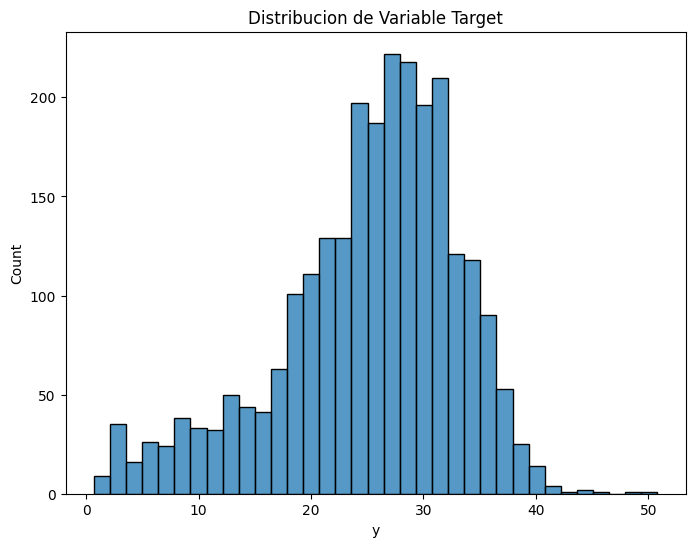

In [597]:
plt.figure(figsize=(8,6))
sns.histplot(restaurantes['y'])
plt.title(label='Distribucion de Variable Target')
plt.show() #distribución de variable Y

In [598]:
restaurantes.describe() 

lat          lon      dine_in  price_level       rating  \
count  2542.000000  2542.000000  2542.000000  2542.000000  2542.000000   
mean     40.429488    -3.697573     0.992132     1.351298     4.160386   
std       0.030001     0.026310     0.088368     0.589589     0.510249   
min      40.380429    -3.760286     0.000000     1.000000     1.000000   
25%      40.404082    -3.716342     1.000000     1.000000     4.000000   
50%      40.425888    -3.698394     1.000000     1.000000     4.200000   
75%      40.455740    -3.675203     1.000000     2.000000     4.500000   
max      40.487670    -3.648047     1.000000     4.000000     5.000000   

        reservable  serves_beer  serves_breakfast  serves_brunch  \
count  2542.000000  2542.000000       2542.000000    2542.000000   
mean      0.933124     0.979544          0.802911       0.948072   
std       0.249857     0.141583          0.397878       0.221925   
min       0.000000     0.000000          0.000000       0.000000   
25%       1.000000     1.000000          1.000000       1.000000   
50%       1.000000     1.000000          1.000000       1.000000   
75%       1.000000     1.000000          1.000000       1.000000   
max       1.000000     1.000000          1.000000       1.000000   

       serves_dinner  serves_lunch  serves_vegetarian_food  serves_wine  \
count    2542.000000   2542.000000             2542.000000  2542.000000   
mean        0.985838      0.993706                0.409127     0.936664   
std         0.118182      0.079102                0.491769     0.243614   
min         0.000000      0.000000                0.000000     0.000000   
25%         1.000000      1.000000                0.000000     1.000000   
50%         1.000000      1.000000                0.000000     1.000000   
75%         1.000000      1.000000                1.000000     1.000000   
max         1.000000      1.000000                1.000000     1.000000   

           takeout  user_ratings_total     delivery    weelchair   hours_open  \
count  2542.000000         2542.000000  2542.000000  2542.000000  2542.000000   
mean      0.976397         1175.741542     0.636900     0.895358    75.050924   
std       0.151840         2395.819922     0.480988     0.306152    25.586959   
min       0.000000            1.000000     0.000000     0.000000     2.000000   
25%       1.000000          166.000000     0.000000     1.000000    56.000000   
50%       1.000000          593.000000     1.000000     1.000000    80.000000   
75%       1.000000         1472.750000     1.000000     1.000000    93.000000   
max       1.000000        63982.000000     1.000000     1.000000   147.000000   

       num_days_open  open_weekends  amusement_park       bakery          bar  \
count    2542.000000    2542.000000     2542.000000  2542.000000  2542.000000   
mean        6.518883       0.812746        0.000393     0.025964     0.321794   
std         0.727974       0.390192        0.019834     0.159059     0.467256   
min         1.000000       0.000000        0.000000     0.000000     0.000000   
25%         6.000000       1.000000        0.000000     0.000000     0.000000   
50%         7.000000       1.000000        0.000000     0.000000     0.000000   
75%         7.000000       1.000000        0.000000     0.000000     1.000000   
max         7.000000       1.000000        1.000000     1.000000     1.000000   

              cafe       casino  convenience_store  grocery_or_supermarket  \
count  2542.000000  2542.000000         2542.00000             2542.000000   
mean      0.087726     0.000787            0.00118                0.012982   
std       0.282952     0.028044            0.03434                0.113218   
min       0.000000     0.000000            0.00000                0.000000   
25%       0.000000     0.000000            0.00000                0.000000   
50%       0.000000     0.000000            0.00000                0.000000   
75%       0.000000     0.000000            0.00000   

Creamos gráficas para evaluar la relación con las variable dependiente y su distribución.

### Price level mean

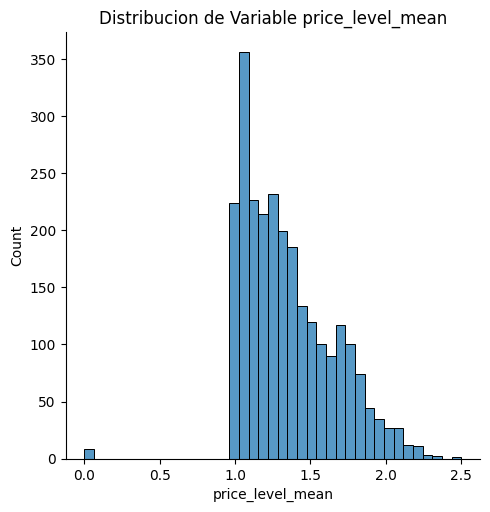

In [599]:
# Sin log
sns.displot(restaurantes['price_level_mean'])
plt.title(label='Distribucion de Variable price_level_mean')
plt.show()

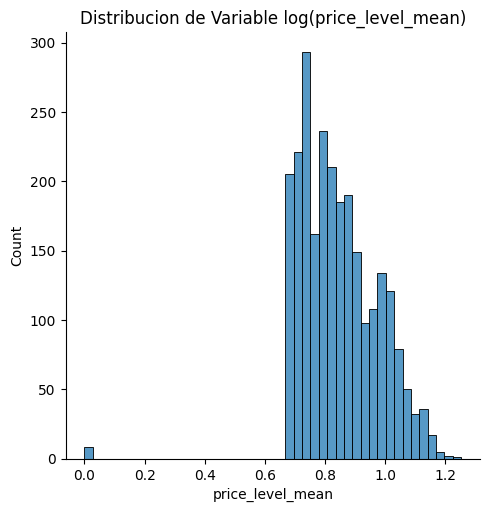

In [600]:
# Con log
sns.displot(np.log1p(restaurantes['price_level_mean']))
plt.title(label='Distribucion de Variable log(price_level_mean)')
plt.show()

La centraliza un por asi que la vamos a cambiar.

In [601]:
restaurantes['price_level_mean'] = [np.log1p(i) for i in restaurantes['price_level_mean']]

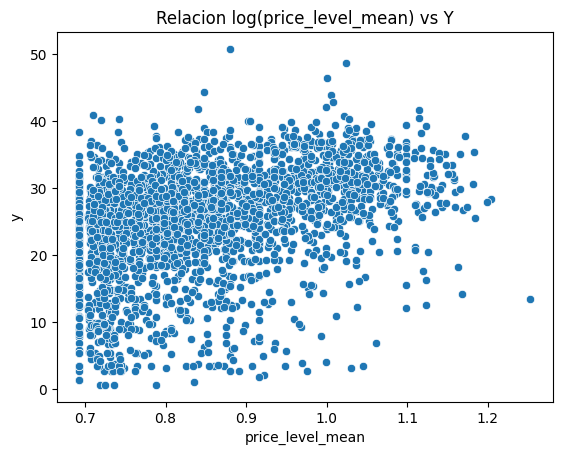

In [602]:
df_sin0 = restaurantes[restaurantes['price_level_mean']!=0]

sns.scatterplot(x=df_sin0['price_level_mean'], y=df_sin0['y'])
plt.title(label='Relacion log(price_level_mean) vs Y')
plt.xlabel('price_level_mean')
plt.ylabel('y')
plt.show() 

# Se ve una leve relacion creciente pero con muchos atipicos

### Rating mean

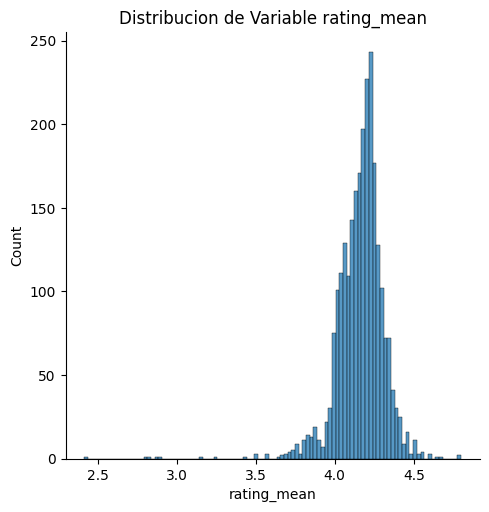

In [603]:
# Sin log
dfrating = restaurantes[restaurantes['rating_mean']!=0]

sns.displot(dfrating['rating_mean'])
plt.title(label='Distribucion de Variable rating_mean')
plt.show()

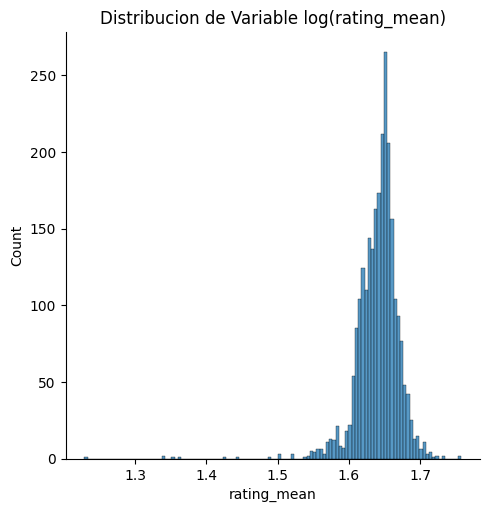

In [604]:
# Con log
sns.displot(np.log1p(dfrating['rating_mean']))
plt.title(label='Distribucion de Variable log(rating_mean)')
plt.show()

No mejora la distribucion por lo que nos quedamos con la variable original.

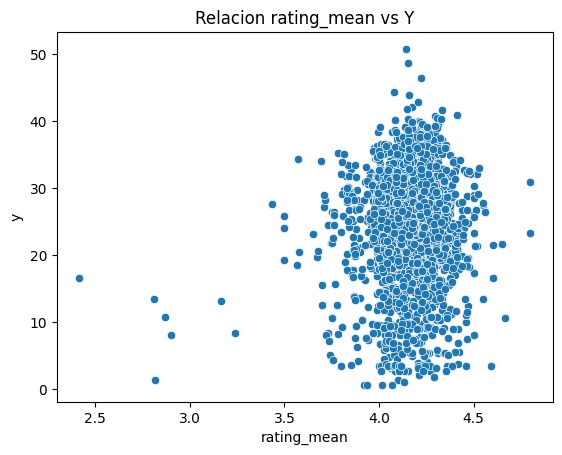

In [605]:
df_sin0 = restaurantes[restaurantes['rating_mean']!=0]

sns.scatterplot(x=df_sin0['rating_mean'], y=df_sin0['y'])
plt.title(label='Relacion rating_mean vs Y')
plt.xlabel('rating_mean')
plt.ylabel('y')
plt.show() 

# Se ve una poco relacion creciente pero con muchos atipicos

### num_restaurantes

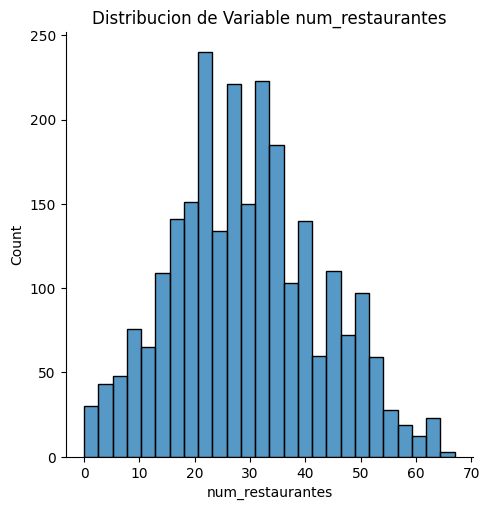

In [606]:
# Sin log
sns.displot(restaurantes['num_restaurantes'])
plt.title(label='Distribucion de Variable num_restaurantes')
plt.show() # Su distribucion es casi normal por lo que no hace falta traformar

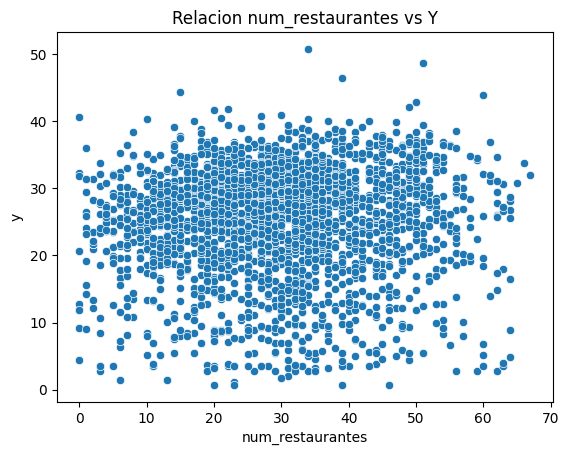

In [607]:
sns.scatterplot(x=restaurantes['num_restaurantes'], y=restaurantes['y'])
plt.title(label='Relacion num_restaurantes vs Y')
plt.xlabel('num_restaurantes')
plt.ylabel('y')
plt.show() 

# No se ve una  relacion pero con muchos atipicos

### anio_medio_constr_vivendas

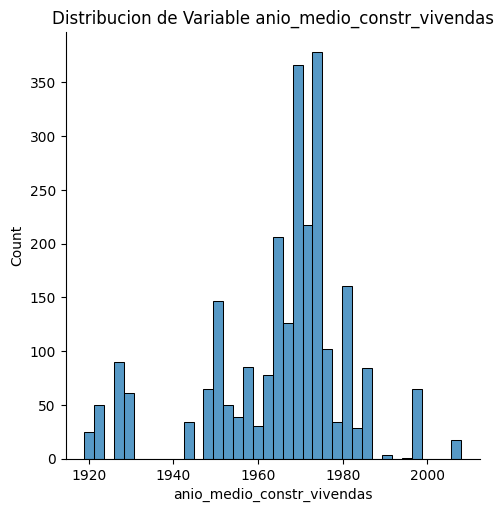

In [608]:
# Sin log
sns.displot(restaurantes['anio_medio_constr_vivendas'])
plt.title(label='Distribucion de Variable anio_medio_constr_vivendas')
plt.show() 

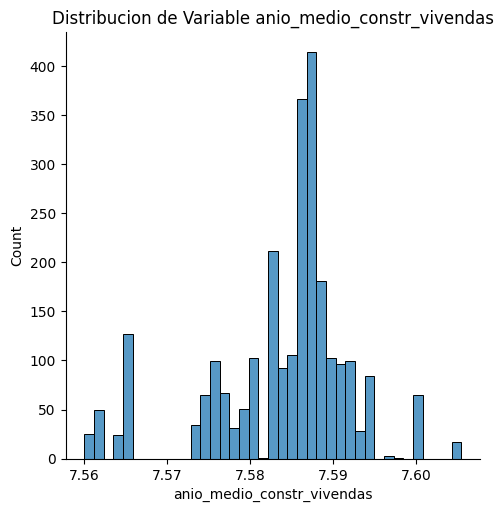

In [609]:
# Con log
sns.displot(np.log1p(restaurantes['anio_medio_constr_vivendas']))
plt.title(label='Distribucion de Variable anio_medio_constr_vivendas')
plt.show()

Nos quedamos con la variable como esta. 

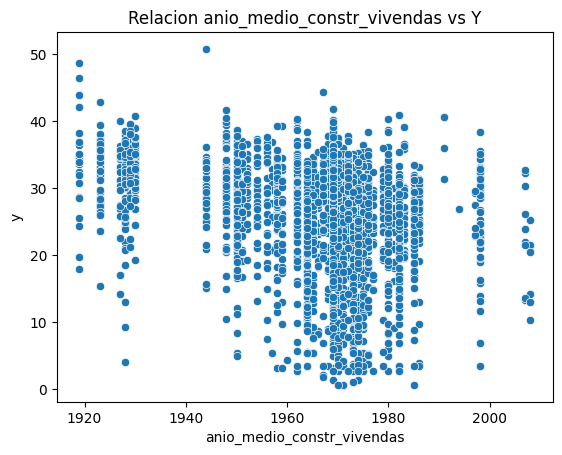

In [610]:
sns.scatterplot(x=restaurantes['anio_medio_constr_vivendas'], y=restaurantes['y'])
plt.title(label='Relacion anio_medio_constr_vivendas vs Y')
plt.xlabel('anio_medio_constr_vivendas')
plt.ylabel('y')
plt.show() 

# No se ve una  relacion pero con muchos atipicos

# dur_media_credito_viviendas

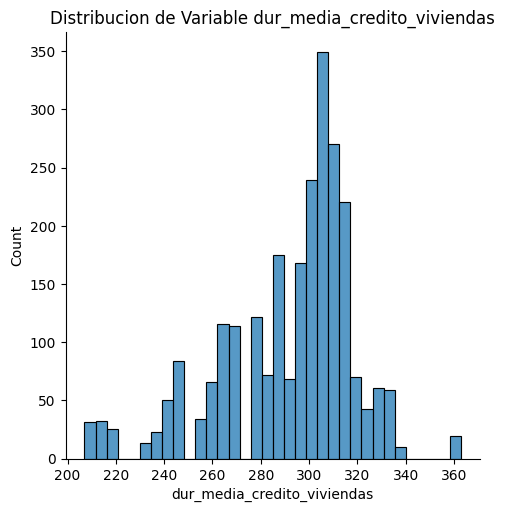

In [611]:
# Sin log
dur_0 = restaurantes[restaurantes['dur_media_credito_viviendas']!=0]

sns.displot(dur_0['dur_media_credito_viviendas'])
plt.title(label='Distribucion de Variable dur_media_credito_viviendas')
plt.show() 

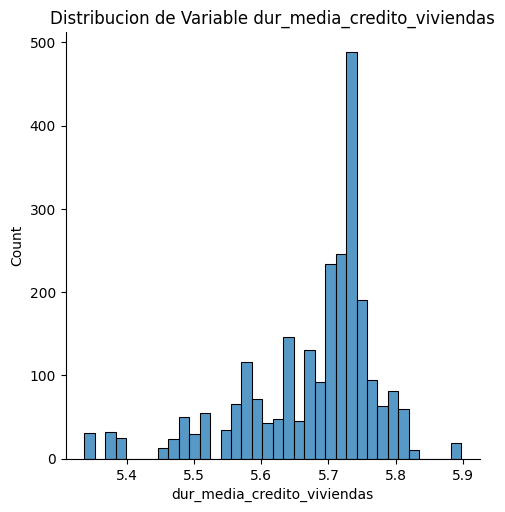

In [612]:
# Con log
dur_0 = restaurantes[restaurantes['dur_media_credito_viviendas']!=0]

sns.displot(np.log1p(dur_0['dur_media_credito_viviendas']))
plt.title(label='Distribucion de Variable dur_media_credito_viviendas')
plt.show() 

La centraliza un poco por lo que vamos a cambiarla.

In [613]:
restaurantes['dur_media_credito_viviendas'] = [np.log1p(i) for i in restaurantes['dur_media_credito_viviendas']]

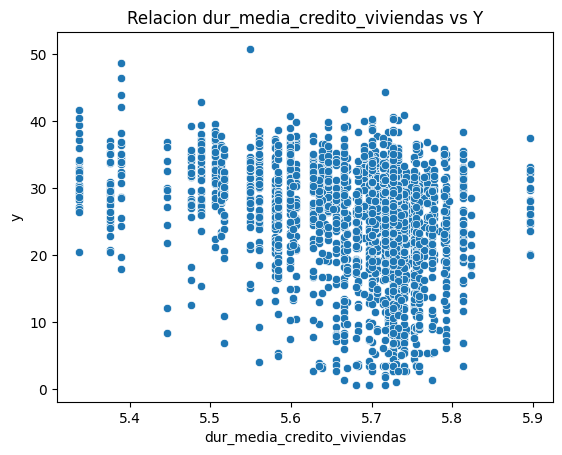

In [614]:
dur_0 = restaurantes[restaurantes['dur_media_credito_viviendas']!=0]

sns.scatterplot(x=dur_0['dur_media_credito_viviendas'], y=dur_0['y'])
plt.title(label='Relacion dur_media_credito_viviendas vs Y')
plt.xlabel('dur_media_credito_viviendas')
plt.ylabel('y')
plt.show() 

# No se ve una relacion un poco decreciente pero muy poco

### valor_catast_inmueble_residen

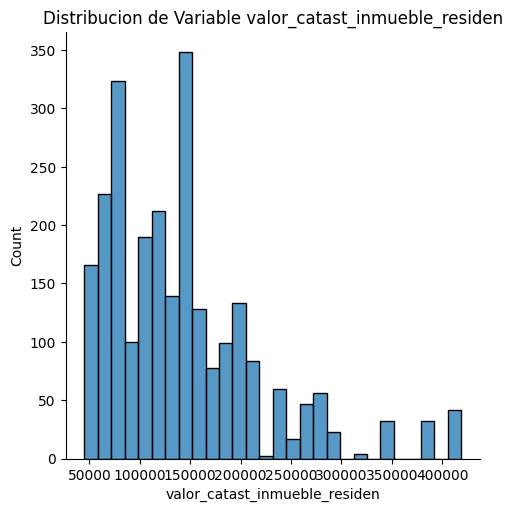

In [615]:
# Sin log
sns.displot(restaurantes['valor_catast_inmueble_residen'])
plt.title(label='Distribucion de Variable valor_catast_inmueble_residen')
plt.show() 

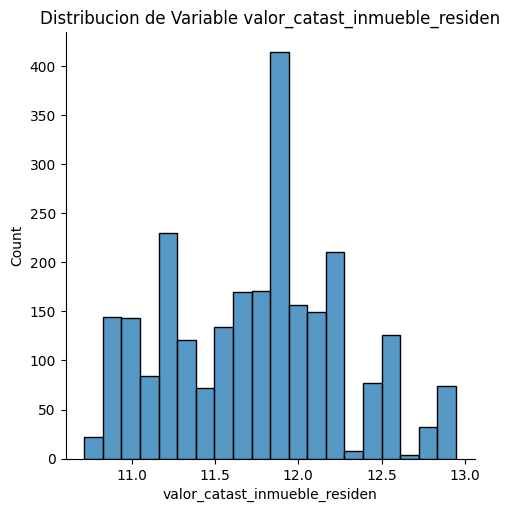

In [616]:
# Con log
sns.displot(np.log1p(restaurantes['valor_catast_inmueble_residen']))
plt.title(label='Distribucion de Variable valor_catast_inmueble_residen')
plt.show() 

Se normaliza bastante por lo que la vamos a cambiar.

In [617]:
restaurantes['valor_catast_inmueble_residen'] = [np.log1p(i) for i in restaurantes['valor_catast_inmueble_residen']]

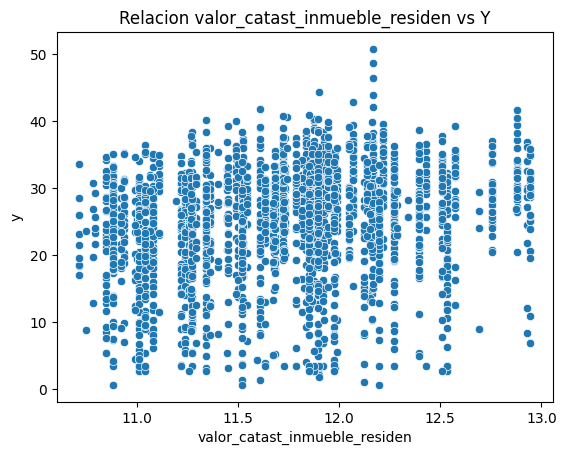

In [618]:
sns.scatterplot(x=restaurantes['valor_catast_inmueble_residen'], y=restaurantes['y'])
plt.title(label='Relacion valor_catast_inmueble_residen vs Y')
plt.xlabel('valor_catast_inmueble_residen')
plt.ylabel('y')
plt.show() 

# No se ve una relacion un poco creciente pero muy poco

### pct_crecimiento_demografico

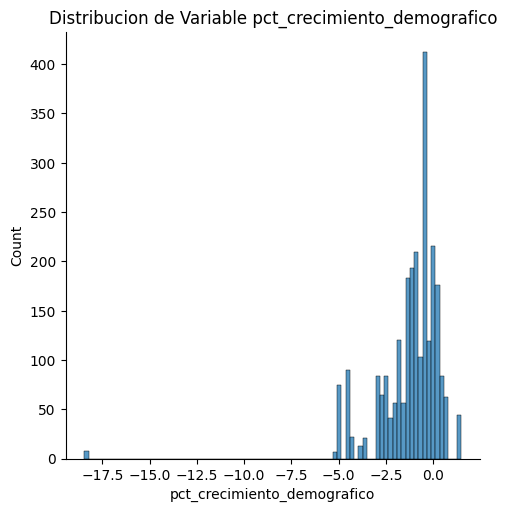

In [619]:
# Sin log
sns.displot(restaurantes['pct_crecimiento_demografico'])
plt.title(label='Distribucion de Variable pct_crecimiento_demografico')
plt.show() # Tiene valores negativos por lo que no hacemos log

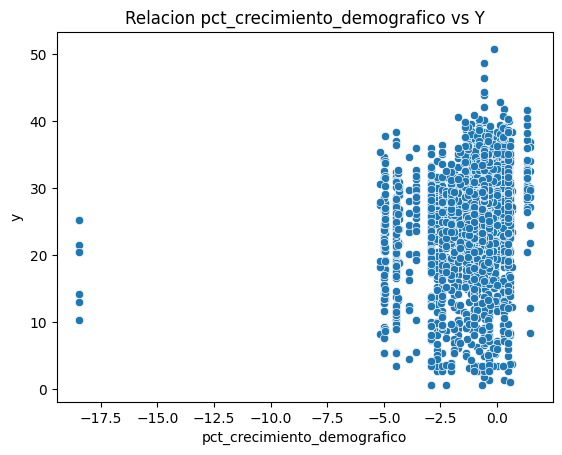

In [620]:
sns.scatterplot(x=restaurantes['pct_crecimiento_demografico'], y=restaurantes['y'])
plt.title(label='Relacion pct_crecimiento_demografico vs Y')
plt.xlabel('pct_crecimiento_demografico')
plt.ylabel('y')
plt.show() 

# No se ve una relacion

### renta_media_persona

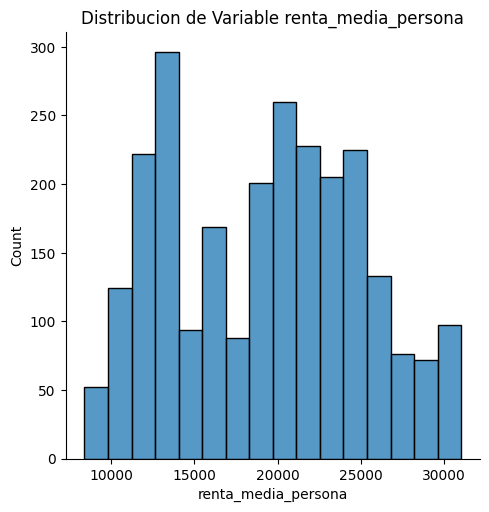

In [621]:
# Sin log
sns.displot(restaurantes['renta_media_persona'])
plt.title(label='Distribucion de Variable renta_media_persona')
plt.show() 

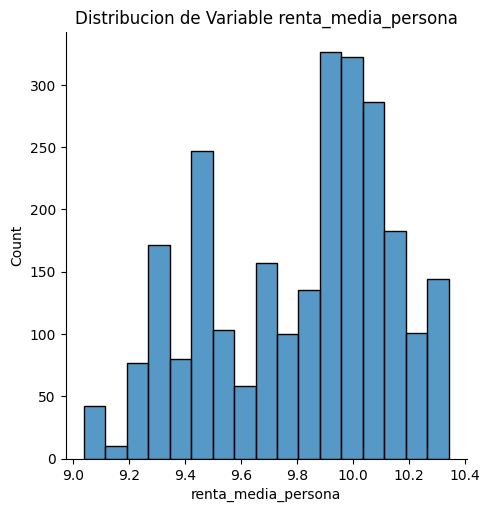

In [622]:
# Con log
sns.displot(np.log1p(restaurantes['renta_media_persona']))
plt.title(label='Distribucion de Variable renta_media_persona')
plt.show() 

Cambia un poco por lo que la vamos a normalizar.

In [623]:
restaurantes['renta_media_persona'] = [np.log1p(i) for i in restaurantes['renta_media_persona']]

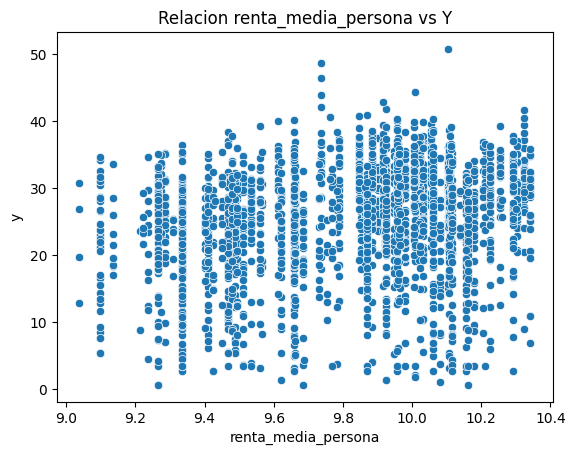

In [624]:
sns.scatterplot(x=restaurantes['renta_media_persona'], y=restaurantes['y'])
plt.title(label='Relacion renta_media_persona vs Y')
plt.xlabel('renta_media_persona')
plt.ylabel('y')
plt.show() 

# No se ve una relacion

### poblacion_densidad

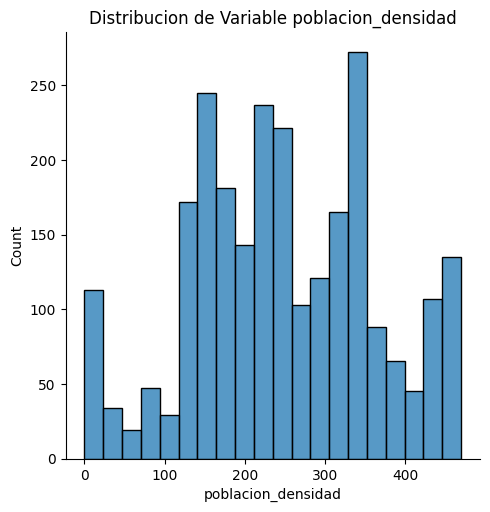

In [625]:
# Sin log
sns.displot(restaurantes['poblacion_densidad'])
plt.title(label='Distribucion de Variable poblacion_densidad')
plt.show() 

Nos quedamos con la variable como esta.

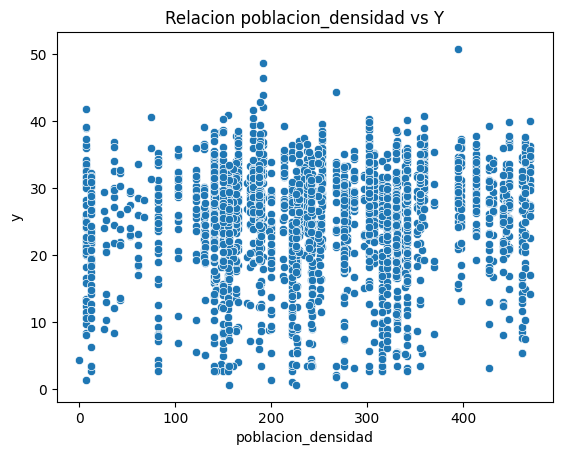

In [626]:
sns.scatterplot(x=restaurantes['poblacion_densidad'], y=restaurantes['y'])
plt.title(label='Relacion poblacion_densidad vs Y')
plt.xlabel('poblacion_densidad')
plt.ylabel('y')
plt.show() 

# No se ve una relacion

### tasa_parados

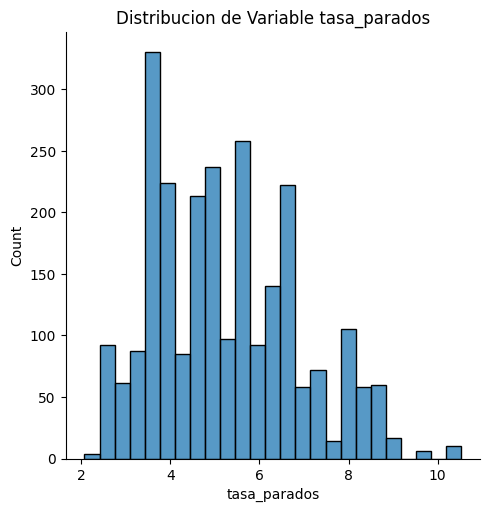

In [627]:
# Sin log
sns.displot(restaurantes['tasa_parados'])
plt.title(label='Distribucion de Variable tasa_parados')
plt.show() 

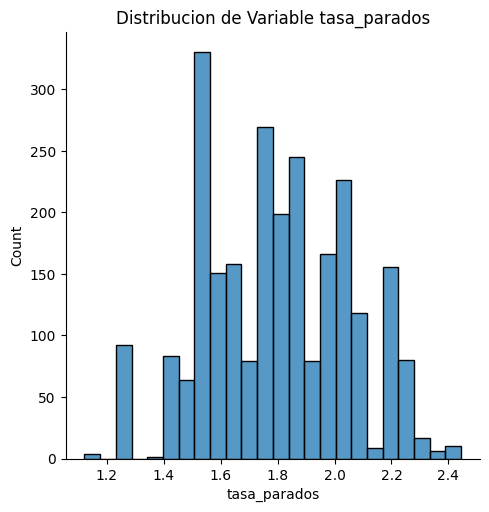

In [628]:
# Con log
sns.displot(np.log1p(restaurantes['tasa_parados']))
plt.title(label='Distribucion de Variable tasa_parados')
plt.show() 

Mejora un poco por lo que la vamos a cambiar.

In [629]:
restaurantes['tasa_parados'] = [np.log1p(i) for i in restaurantes['tasa_parados']]

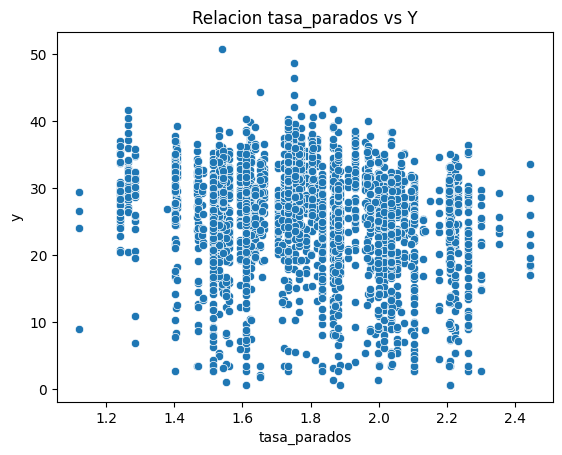

In [630]:
sns.scatterplot(x=restaurantes['tasa_parados'], y=restaurantes['y'])
plt.title(label='Relacion tasa_parados vs Y')
plt.xlabel('tasa_parados')
plt.ylabel('y')
plt.show() 

# No se ve realacion clara

### hours_open

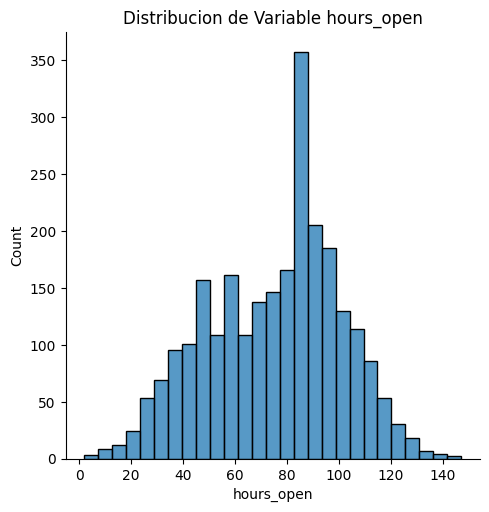

In [631]:
# Sin log
sns.displot(restaurantes['hours_open'])
plt.title(label='Distribucion de Variable hours_open')
plt.show() 

Esta bastante centralizada.

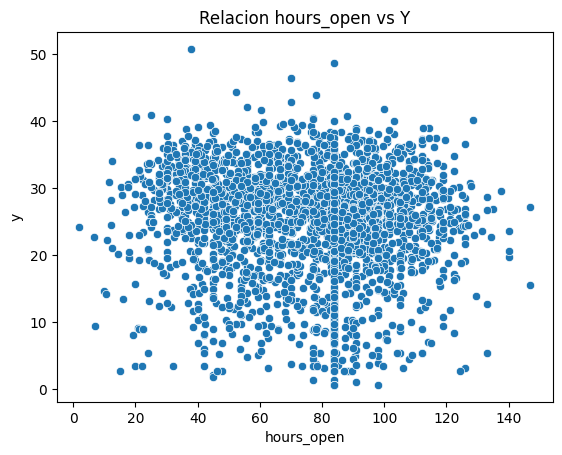

In [632]:
sns.scatterplot(x=restaurantes['hours_open'], y=restaurantes['y'])
plt.title(label='Relacion hours_open vs Y')
plt.xlabel('hours_open')
plt.ylabel('y')
plt.show() 

# No se ve realacion clara

### num_days_open

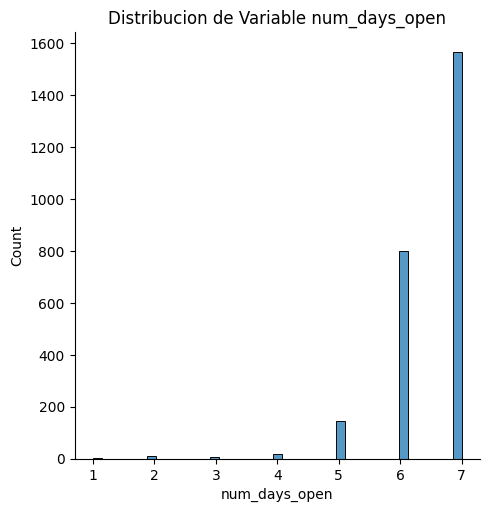

In [633]:
# Sin log
sns.displot(restaurantes['num_days_open'])
plt.title(label='Distribucion de Variable num_days_open')
plt.show() 

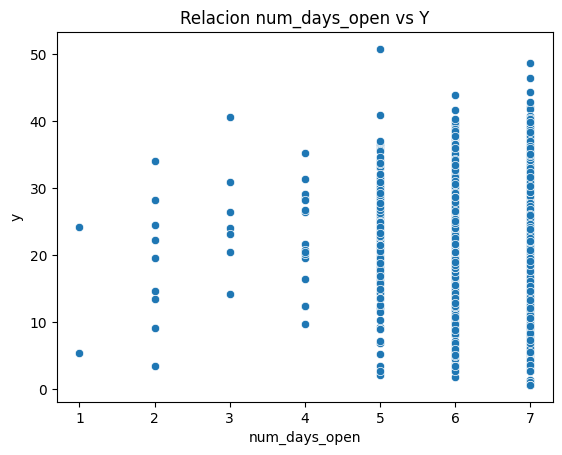

In [634]:
sns.scatterplot(x=restaurantes['num_days_open'], y=restaurantes['y'])
plt.title(label='Relacion num_days_open vs Y')
plt.xlabel('num_days_open')
plt.ylabel('y')
plt.show() 

# No se ve realacion clara

### num_locales_alta_abiertos

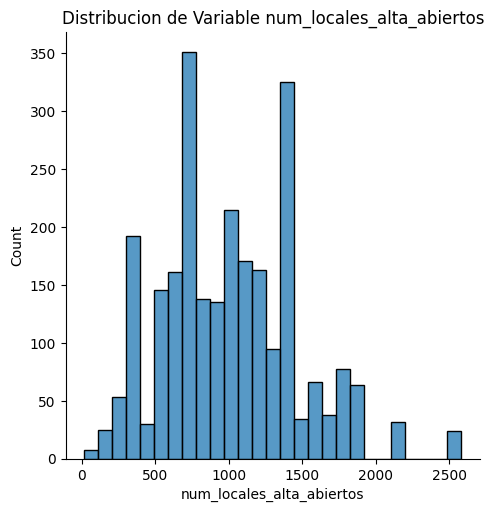

In [635]:
# Sin log
sns.displot(restaurantes['num_locales_alta_abiertos'])
plt.title(label='Distribucion de Variable num_locales_alta_abiertos')
plt.show() 

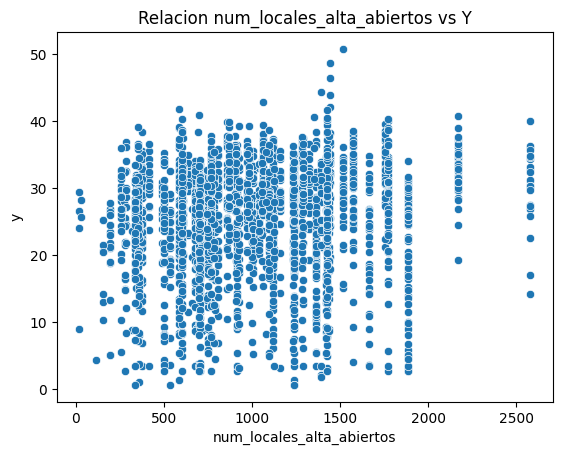

In [636]:
sns.scatterplot(x=restaurantes['num_locales_alta_abiertos'], y=restaurantes['y'])
plt.title(label='Relacion num_locales_alta_abiertos vs Y')
plt.xlabel('num_locales_alta_abiertos')
plt.ylabel('y')
plt.show() 

# No se ve realacion clara

### num_locales_alta_cerrados

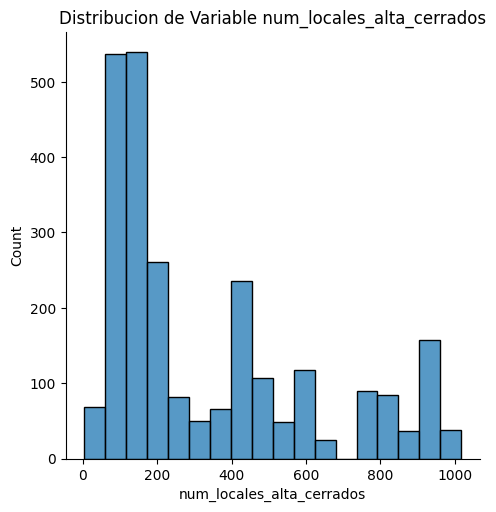

In [637]:
# Sin log
sns.displot(restaurantes['num_locales_alta_cerrados'])
plt.title(label='Distribucion de Variable num_locales_alta_cerrados')
plt.show() 

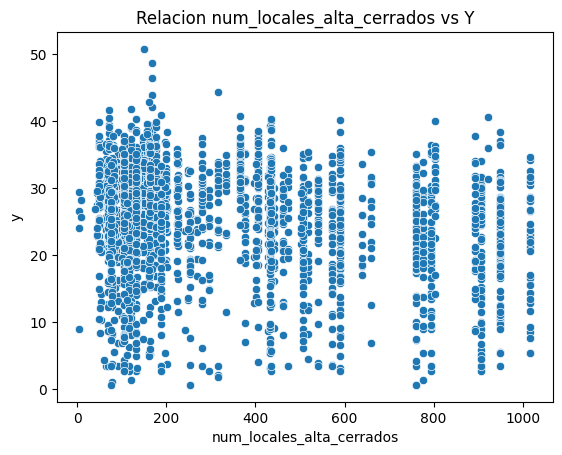

In [638]:
sns.scatterplot(x=restaurantes['num_locales_alta_cerrados'], y=restaurantes['y'])
plt.title(label='Relacion num_locales_alta_cerrados vs Y')
plt.xlabel('num_locales_alta_cerrados')
plt.ylabel('y')
plt.show() 

# No se ve realacion clara

# poblacion_80_mas

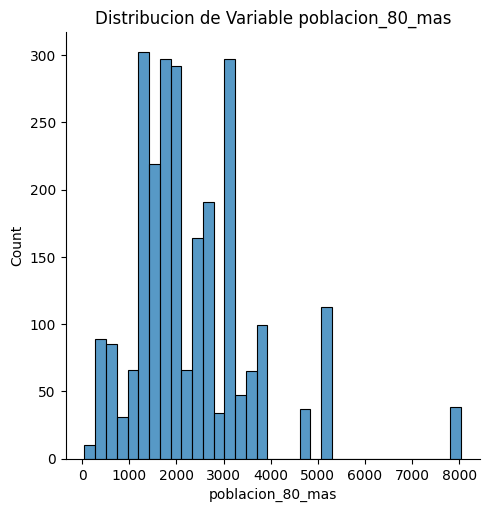

In [639]:
# Sin log
sns.displot(restaurantes['poblacion_80_mas'])
plt.title(label='Distribucion de Variable poblacion_80_mas')
plt.show() 

Nos quedamos con la variable como esta.

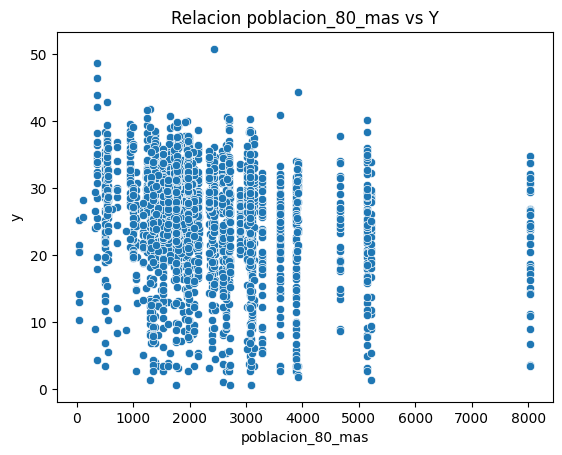

In [640]:
sns.scatterplot(x=restaurantes['poblacion_80_mas'], y=restaurantes['y'])
plt.title(label='Relacion poblacion_80_mas vs Y')
plt.xlabel('poblacion_80_mas')
plt.ylabel('y')
plt.show() 

# No se ve realacion clara

# poblacion_italia

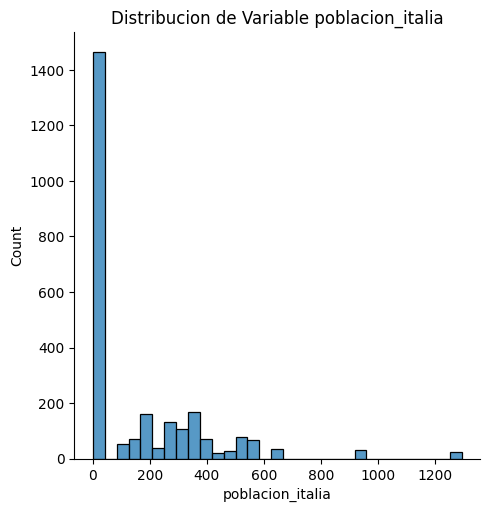

In [641]:
# Sin log
sns.displot(restaurantes['poblacion_italia'])
plt.title(label='Distribucion de Variable poblacion_italia')
plt.show() 

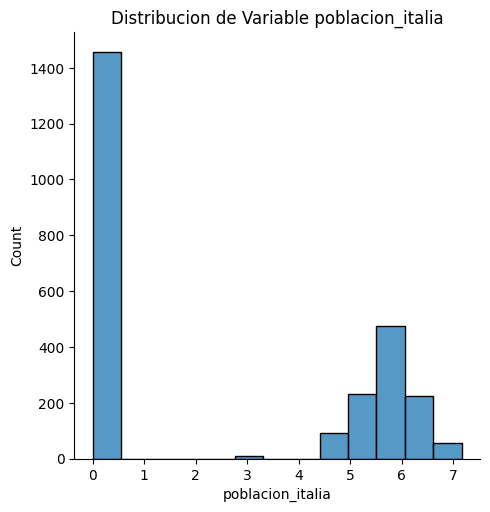

In [642]:
# Con log
sns.displot(np.log1p(restaurantes['poblacion_italia']))
plt.title(label='Distribucion de Variable poblacion_italia')
plt.show() 

In [643]:
restaurantes['poblacion_italia'] = [np.log1p(i) for i in restaurantes['poblacion_italia']]

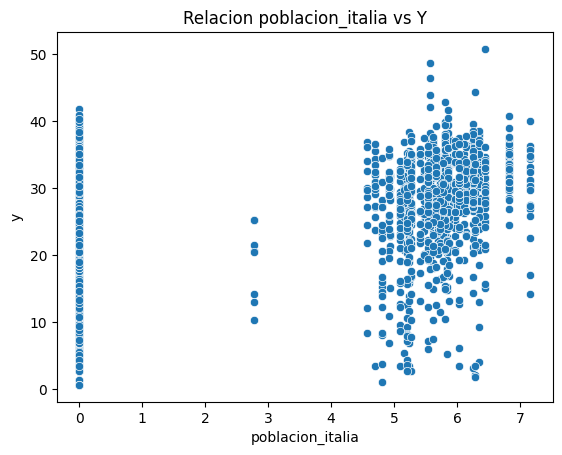

In [644]:
sns.scatterplot(x=restaurantes['poblacion_italia'], y=restaurantes['y'])
plt.title(label='Relacion poblacion_italia vs Y')
plt.xlabel('poblacion_italia')
plt.ylabel('y')
plt.show() 

# No se ve realacion clara

# poblacion_china

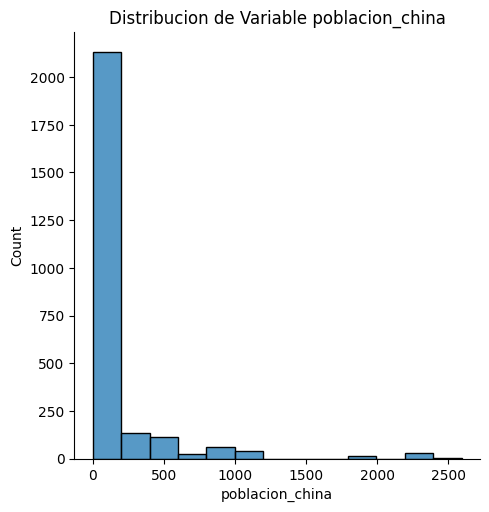

In [645]:
# Sin log
sns.displot(restaurantes['poblacion_china'])
plt.title(label='Distribucion de Variable poblacion_china')
plt.show() 

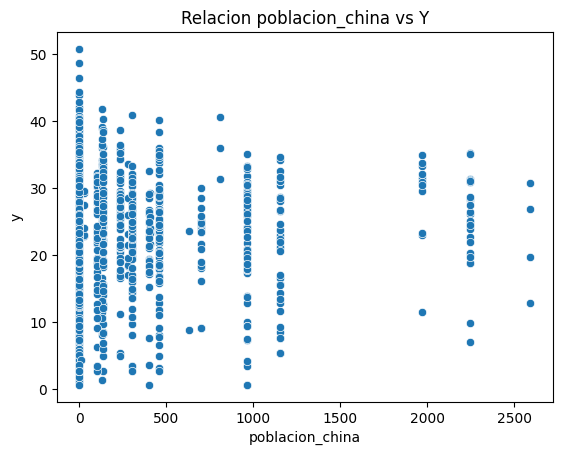

In [646]:
sns.scatterplot(x=restaurantes['poblacion_china'], y=restaurantes['y'])
plt.title(label='Relacion poblacion_china vs Y')
plt.xlabel('poblacion_china')
plt.ylabel('y')
plt.show() 

# No se ve realacion clara

Ahora miramos las correlaciones que tiene las variables para resspandarnos, en nuestros graficas.

In [647]:
corr = restaurantes.corr(numeric_only=True)

In [648]:
''' 
Evaluamos las correlaciones y nos quedamos con las variables que tengan un correlacion >=(abs(0.2))
'''

val = corr[(corr['y']>=0.2)|(corr['y']<=-0.2)].sort_values(by='y')
val

lat       lon   dine_in  price_level  \
serves_breakfast              -0.020385 -0.052770  0.034231    -0.320426   
anio_medio_constr_vivendas     0.180406  0.095034 -0.027239    -0.260478   
cod_distrito                   0.061678  0.076968 -0.047268    -0.278735   
cod_barrio                     0.072509  0.088435 -0.046875    -0.276849   
num_locales_alta_cerrados     -0.315539 -0.223395 -0.060880    -0.254787   
tasa_parados                  -0.433420 -0.213710 -0.024802    -0.319840   
poblacion_80_mas               0.068781 -0.200582 -0.054232    -0.199791   
pct_crecimiento_demografico    0.229894  0.077657  0.037656     0.212950   
open_weekends                 -0.075926  0.003970  0.048564     0.142359   
renta_media_persona            0.493870  0.251618  0.031418     0.346129   
valor_catast_inmueble_residen  0.449461  0.227088  0.034471     0.359187   
Centro                        -0.133458 -0.076379  0.027818     0.179630   
poblacion_italia              -0.106291  0.241161  0.041574     0.316519   
price_level_mean               0.153218  0.242313  0.053548     0.413454   
rating                         0.014054  0.007821 -0.064520     0.108154   
user_ratings_mean             -0.029103  0.110925  0.063073     0.330373   
price_level                    0.082915  0.109045  0.053071     1.000000   
user_ratings_total            -0.009070  0.040072  0.034667     0.238552   
y                              0.022670  0.117230  0.083222     0.433992   

                                 rating  reservable  serves_beer  \
serves_breakfast              -0.116012    0.013835     0.061138   
anio_medio_constr_vivendas    -0.053056   -0.003528    -0.005378   
cod_distrito                  -0.026424    0.035653    -0.044559   
cod_barrio                    -0.028197    0.035102    -0.044020   
num_locales_alta_cerrados      0.010081    0.041677    -0.079788   
tasa_parados                  -0.017712    0.024654    -0.057242   
poblacion_80_mas              -0.010268    0.030516    -0.033837   
pct_crecimiento_demografico   -0.011880   -0.006602     0.052047   
open_weekends                 -0.066132   -0.039694    -0.033746   
renta_media_persona            0.025573   -0.029382     0.075825   
valor_catast_inmueble_residen  0.040970   -0.023536     0.069257   
Centro                         0.041598    0.000631     0.025614   
poblacion_italia               0.026920   -0.032182     0.034107   
price_level_mean               0.055727   -0.043618     0.045052   
rating                         1.000000    0.083857    -0.001416   
user_ratings_mean              0.017281   -0.046900     0.031155   
price_level                    0.108154    0.095428     0.038977   
user_ratings_total             0.063591   -0.039039     0.023553   
y                              0.367092   -0.043564     0.017247   

                               serves_breakfast  serves_brunch  serves_dinner  \
serves_breakfast                       1.000000       0.338660       0.032681   
anio_medio_constr_vivendas             0.149894       0.039941      -0.026031   
cod_distrito                           0.148184       0.055889      -0.019517   
cod_barrio                             0.147653       0.055113      -0.019531   
num_locales_alta_cerrados              0.097984       0.022529      -0.034881   
tasa_parados                           0.096680       0.030887      -0.021608   
poblacion_80_mas                       0.083388       0.037432      -0.032688   
pct_crecimiento_demografico           -0.103122      -0.023103       0.022164   
open_weekends                         -0.164300      -0.048709       0.087552   
renta_media_persona                   -0.123068      -0.029770       0.023997   
valor_catast_inmueble_residen         -0.124091      -0.044928       0.027889   
Centro                                -0.119729      -0.051483       0.025743   
poblacion_italia                      -0.165071      -0.060285       0.035356   
price_level_mean    

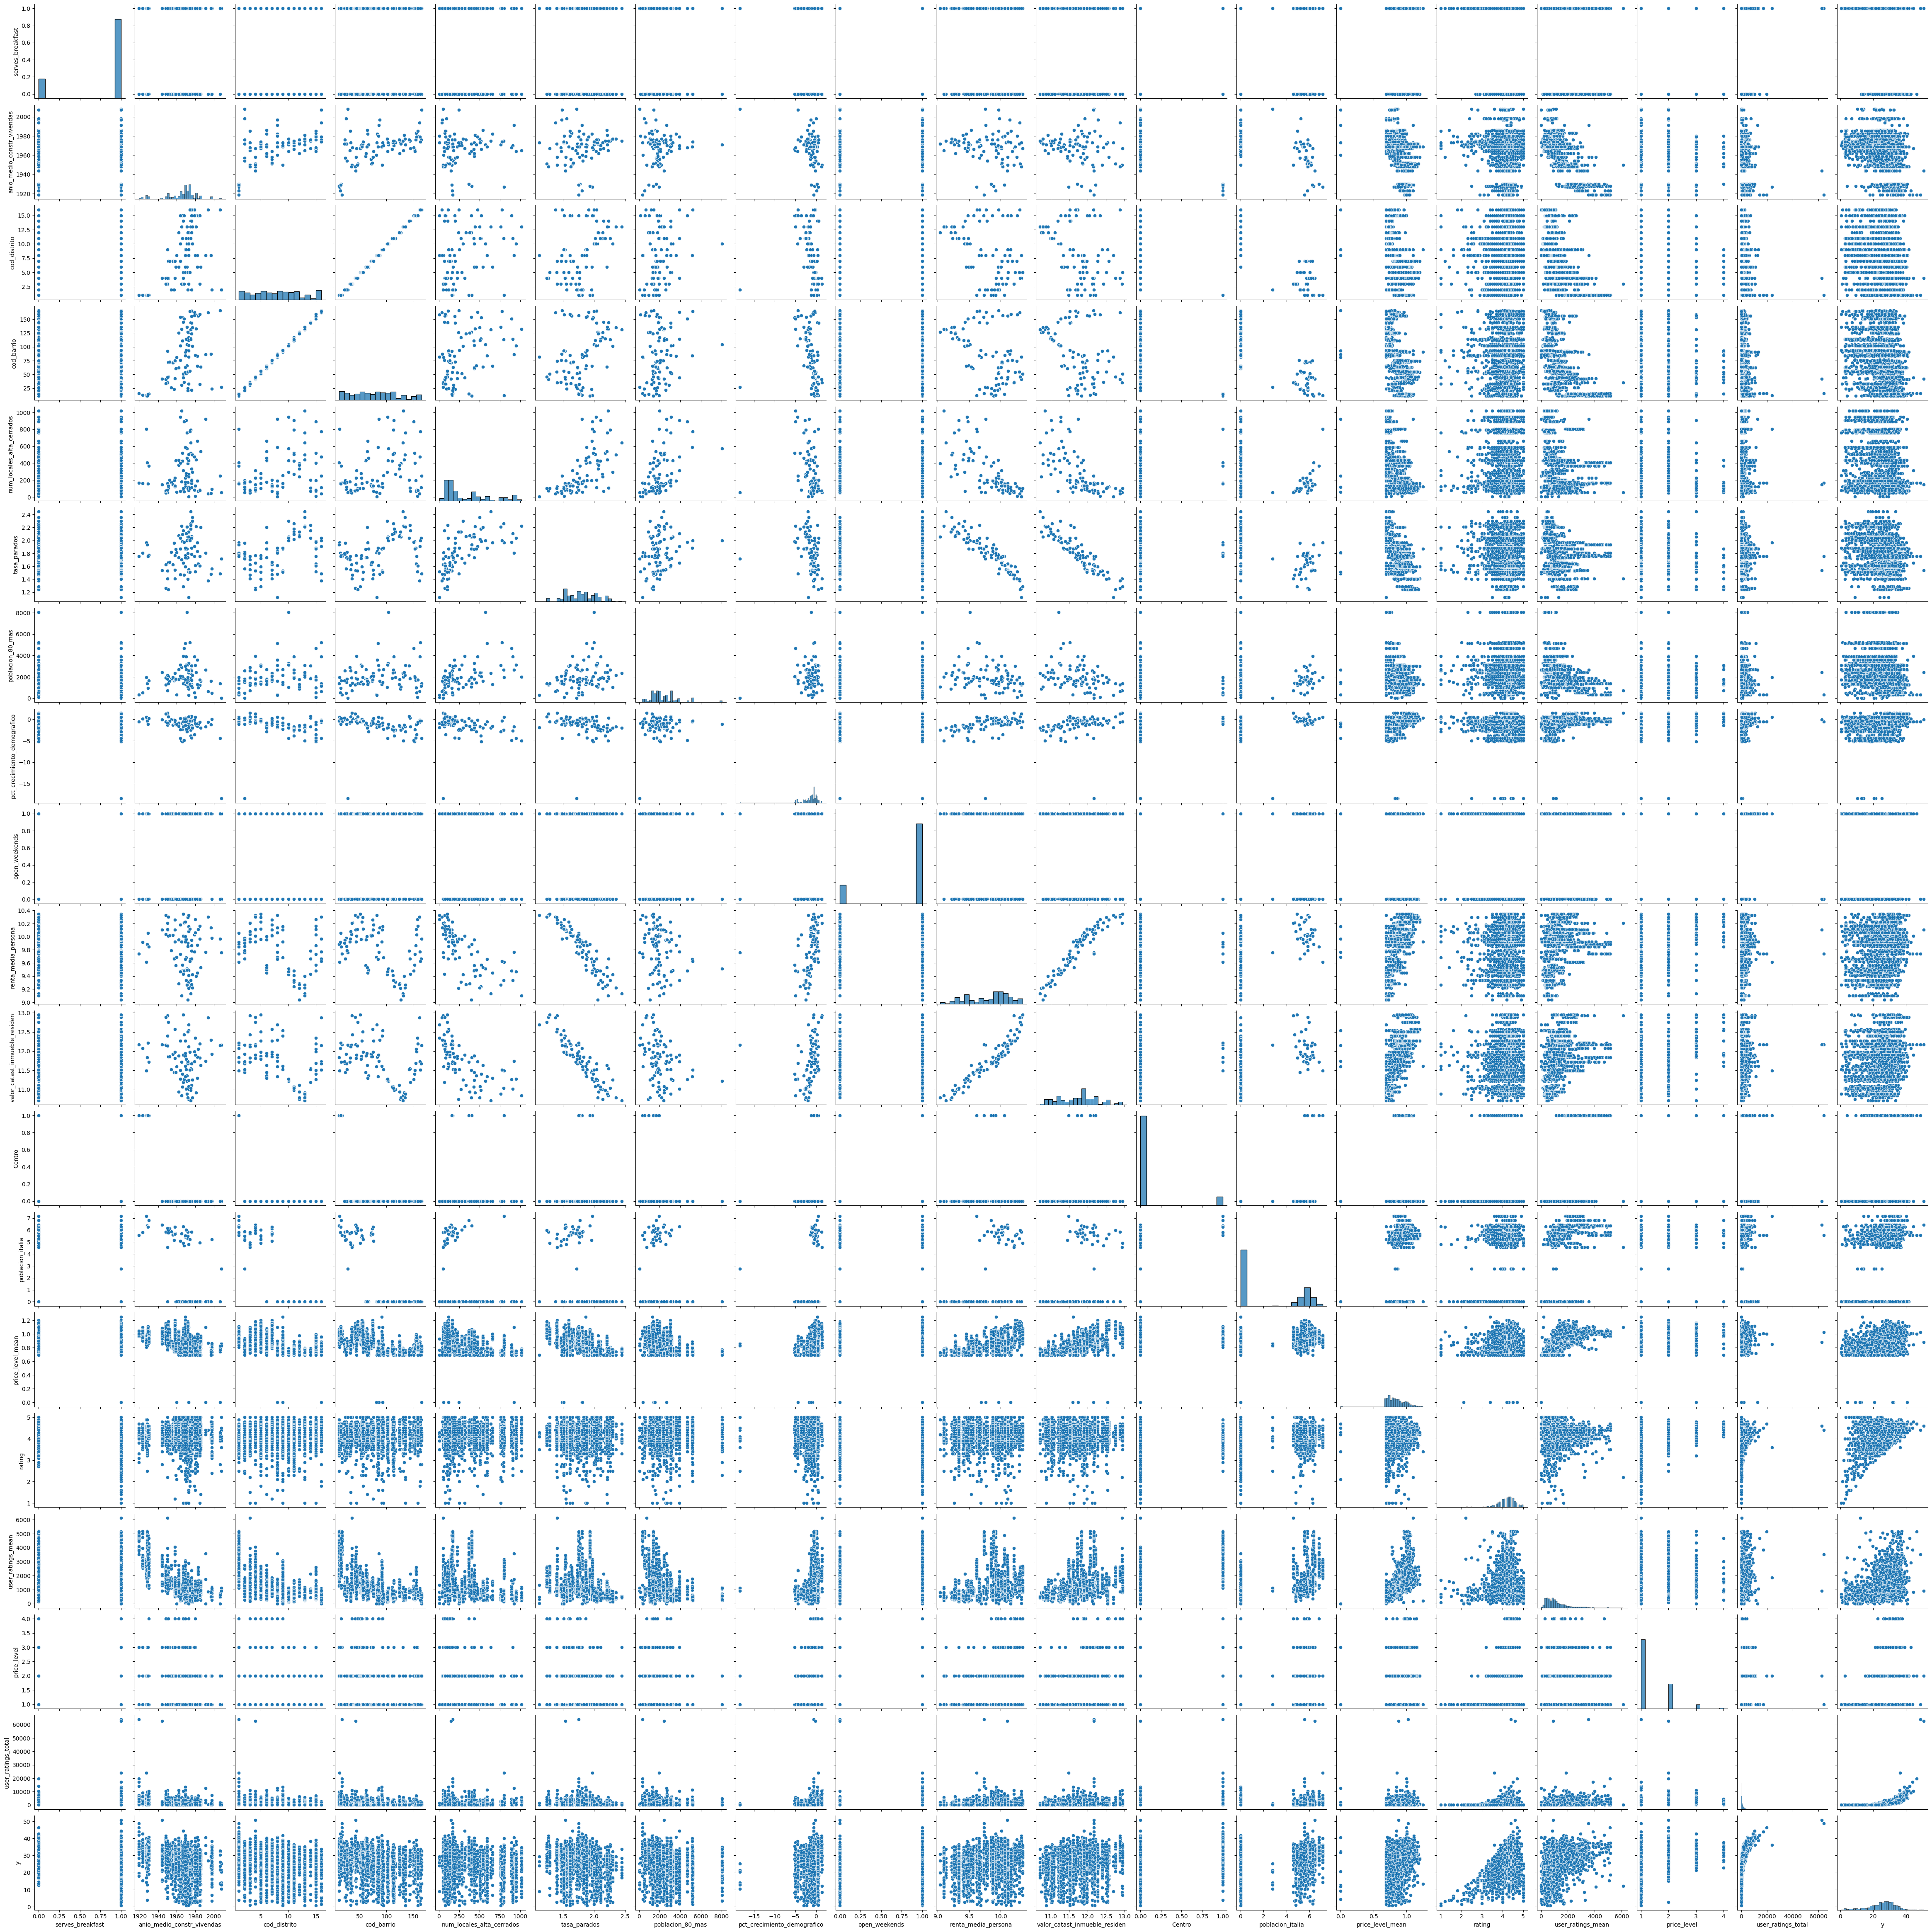

In [649]:
sns.pairplot(restaurantes.loc[:, val.index.values]);

In [650]:
restaurantes.groupby('cod_barrio')[['y']].describe()

y                                                        \
           count       mean       std        min        25%        50%   
cod_barrio                                                               
11          66.0  30.691795  6.647247   4.023595  28.937676  32.038015   
12          24.0  30.476709  6.058173  14.287890  27.517883  31.205797   
13          50.0  32.348622  4.875065  15.380572  28.490427  32.941697   
14          29.0  32.939105  4.526010  21.296246  30.829459  33.472726   
15          32.0  32.683273  4.425922  19.252548  30.122503  33.055585   
...          ...        ...       ...        ...        ...        ...   
162          1.0  26.958224       NaN  26.958224  26.958224  26.958224   
163         13.0  24.269655  7.769020   3.502638  20.721933  25.507816   
164         34.0  21.033639  7.587892   1.386294  18.304061  22.150944   
165         17.0  20.855030  6.924811   5.129289  18.987785  23.102637   
166          9.0  23.992442  7.259414  13.285810  21.574510  23.860579   

                                  
                  75%        max  
cod_barrio                        
11          34.682049  38.599435  
12          34.728956  40.072057  
13          35.994775  42.837069  
14          36.069059  39.536516  
15          35.544269  40.731785  
...               ...        ...  
162         26.958224  26.958224  
163         30.223664  32.836272  
164         25.126501  33.863013  
165         25.973425  27.748506  
166         30.330002  32.722407  

[89 rows x 8 columns]

In [651]:
restaurantes.to_csv('../data/processed/restaurantes.csv', index=False)